In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV,train_test_split,RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,HistGradientBoostingClassifier,StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score,average_precision_score,f1_score,confusion_matrix,ConfusionMatrixDisplay,precision_score,recall_score,roc_curve,RocCurveDisplay,PrecisionRecallDisplay
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
import scipy.stats as st
from sklearn.ensemble import RandomForestRegressor


In [2]:
scoring_metric = "roc_auc"
def woe_encoder(categorical_variables,label_name,train,test):
    eps = 0.001
    ans = train.copy()
    ans2 = test.copy()
    num_pos = (data[[label_name]] == 1).sum()
    num_neg = len(data) - num_pos
    for category in categorical_variables:
        u = data[category].unique()
        for val in u:
            d = ans[ans[category] == val]
            pos = (d[label_name] == 1).sum()/num_pos
            neg = (d[label_name]==0).sum()/num_neg
            woe = np.log((pos + eps)/(neg + eps)).squeeze()
            ans.loc[ans[category] == val,category] = woe
            ans2.loc[ans2[category] == val,category] = woe
    return ans,ans2
d = pd.read_excel('taiwan_data.xlsx',skiprows=1,index_col=0)
d['LIMIT_BAL'].describe()
len(d)

30000

In [3]:
len(d)

30000

In [4]:
data = d[d.index <= 2000]
test = d[d.index >= 29901]
categorical_variables2 = ['SEX','EDUCATION','MARRIAGE',"PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]
data,test = woe_encoder(categorical_variables2,'default payment next month',data,test)
X_train = data.drop(columns=["default payment next month"],axis=1)
X_test = test.drop(columns=["default payment next month"],axis=1)
y_train = (data[['default payment next month']]).squeeze()
y_test = (test[['default payment next month']]).squeeze()
mu  = X_train.mean()
s = X_train.std()
X_train = (X_train - mu)/s
X_test = (X_test - mu)/s
param_grid = {"estimator":[LogisticRegression()],
              "n_estimators":[1,10,50,250,1000],
              "learning_rate":[0.5,1,1.5]}
Model1 = GridSearchCV(AdaBoostClassifier(),param_grid,cv=10,scoring=scoring_metric,n_jobs=4,verbose=1)
Model1.fit(X_train,y_train)
probabilities = Model1.predict_proba(X_test)[:, 1]
result_df = X_test.copy()
result_df['Probability of Default'] = probabilities
#added new credit limit column


Fitting 10 folds for each of 15 candidates, totalling 150 fits


In [5]:
# Calculate 'CCF' while handling division by zero
def calculate_ccf(row):
    ob_at_default = row['OB at default']
    ob_at_beg = row['OB at beg.']
    limit_bal = row['LIMIT_BAL']

    if limit_bal - ob_at_beg == 0:
        return 0  # Set 'CCF' to 0 when denominator is 0
    else:
        return (ob_at_default - ob_at_beg) / (limit_bal - ob_at_beg)

# Calculate 'OB at beg.', 'OB at default', 'CCF numerator', and 'CCF denominator'
d['OB at beg.'] = d['BILL_AMT1']
d['OB at default'] = d['BILL_AMT1'] - d['PAY_AMT1'] + (0.3 / 12) * d['BILL_AMT1']
d['CCF numerator'] = d['OB at default'] - d['OB at beg.']
d['CCF denominator'] = d['LIMIT_BAL'] - d['OB at beg.']
for i in range(1,7):
    d[f'OB{i}'] = (d[f'BILL_AMT{i}'] - d[f'PAY_AMT{i}'])+ (0.3 / 12) * d[f'BILL_AMT{i}']
    
d['avg_OB']=(d['OB1']+d['OB2']+d['OB3']+d['OB4']+d['OB5']+d['OB6'])/6
# Calculate 'CCF' while handling division by zero
d['CCF'] = d.apply(calculate_ccf, axis=1)

# Drop rows with NaN values
df_cleaned = d.dropna()

# Calculate 'EAD'
df_cleaned['EAD'] = df_cleaned['OB at default'] + df_cleaned['CCF'] * (df_cleaned['LIMIT_BAL'] - df_cleaned['OB at default'])
# Calculate IQR
Q1 = df_cleaned['EAD'].quantile(0.25)
Q3 = df_cleaned['EAD'].quantile(0.75)
IQR = Q3 - Q1

# Define threshold and filter outliers
threshold = 1.5
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR
df_cleaned = df_cleaned[(df_cleaned['EAD'] >= lower_bound) & (df_cleaned['EAD'] <= upper_bound)&(df_cleaned['EAD'] >=0)]

# Describe 'EAD' column after removing outliers
print(df_cleaned['EAD'].describe())
df_cleaned
#Assume LGD =0.5
df_cleaned['LGD']=0.5
merged_df = df_cleaned.merge(result_df[['Probability of Default']], left_index=True, right_index=True)
#beta is set to be 0.5
beta=0.5
merged_df['New Credit Limit'] = merged_df['LIMIT_BAL']*(1+beta)
merged_df
merged_df['E(Loss)']=merged_df['Probability of Default']*merged_df['LGD']*merged_df['EAD']
merged_df

count     20958.000000
mean      38941.976159
std       38936.508441
min           0.000000
25%        6345.003524
50%       25735.867671
75%       59848.696390
max      153809.356233
Name: EAD, dtype: float64


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,OB4,OB5,OB6,avg_OB,CCF,EAD,LGD,Probability of Default,New Credit Limit,E(Loss)
ID,,,,,,,,,,,,,,,,,,,,,
29901,20000,1,2,2,29,0,0,-2,-2,-2,...,0.000,0.000,0.000,2871.537500,0.131691,17594.110279,0.5,0.469901,30000.0,4133.749119
29902,50000,1,2,2,29,1,2,0,0,0,...,50291.750,50296.200,49840.675,58130.108333,-1.504290,55299.390551,0.5,0.485621,75000.0,13427.259458
29904,260000,1,1,1,30,-1,0,-1,-1,-1,...,2.475,-172002.525,146393.600,1696.895833,-0.040123,8336.407667,0.5,0.470841,390000.0,1962.562490
29905,60000,1,3,2,30,0,0,0,0,0,...,58200.300,59788.650,59759.200,55670.270833,-0.242908,52201.746109,0.5,0.467119,90000.0,12192.215710
29906,50000,1,3,1,30,1,2,2,0,0,...,18415.750,18748.000,13906.525,17180.079167,-0.026537,15730.047502,0.5,0.499668,75000.0,3929.898971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29992,210000,1,2,1,34,3,2,2,2,2,...,2562.500,2562.500,2562.500,2562.500000,0.000301,2624.981175,0.5,0.508457,315000.0,667.344683
29993,10000,1,3,1,43,0,0,0,-2,-2,...,0.000,0.000,0.000,2947.008333,-1.485768,2597.507343,0.5,0.473565,15000.0,615.044179
29995,80000,1,2,2,34,2,2,2,2,2,...,72456.975,84672.175,79186.950,76867.720833,-0.696772,58571.337451,0.5,0.514638,120000.0,15071.508174


In [6]:
# Assuming df is your DataFrame
X = merged_df.drop(['avg_OB', 'New Credit Limit'], axis=1)
y = merged_df['avg_OB']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a regressor for avg_OB prediction
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

# Create a new DataFrame with the new credit limit value
X_new_credit_limit = merged_df.drop(['avg_OB', 'New Credit Limit'], axis=1)
X_new_credit_limit['LIMIT_BAL'] = merged_df['New Credit Limit']

# Predict avg_OB for the new credit limit
y_new_credit_limit_pred = regressor.predict(X_new_credit_limit)
merged_df['R_a'] = y_new_credit_limit_pred
merged_df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,OB5,OB6,avg_OB,CCF,EAD,LGD,Probability of Default,New Credit Limit,E(Loss),R_a
ID,,,,,,,,,,,,,,,,,,,,,
29901,20000,1,2,2,29,0,0,-2,-2,-2,...,0.000,0.000,2871.537500,0.131691,17594.110279,0.5,0.469901,30000.0,4133.749119,3153.479792
29902,50000,1,2,2,29,1,2,0,0,0,...,50296.200,49840.675,58130.108333,-1.504290,55299.390551,0.5,0.485621,75000.0,13427.259458,57192.461542
29904,260000,1,1,1,30,-1,0,-1,-1,-1,...,-172002.525,146393.600,1696.895833,-0.040123,8336.407667,0.5,0.470841,390000.0,1962.562490,5392.615708
29905,60000,1,3,2,30,0,0,0,0,0,...,59788.650,59759.200,55670.270833,-0.242908,52201.746109,0.5,0.467119,90000.0,12192.215710,55460.211750
29906,50000,1,3,1,30,1,2,2,0,0,...,18748.000,13906.525,17180.079167,-0.026537,15730.047502,0.5,0.499668,75000.0,3929.898971,13303.874542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29992,210000,1,2,1,34,3,2,2,2,2,...,2562.500,2562.500,2562.500000,0.000301,2624.981175,0.5,0.508457,315000.0,667.344683,2862.328917
29993,10000,1,3,1,43,0,0,0,-2,-2,...,0.000,0.000,2947.008333,-1.485768,2597.507343,0.5,0.473565,15000.0,615.044179,4649.335417
29995,80000,1,2,2,34,2,2,2,2,2,...,84672.175,79186.950,76867.720833,-0.696772,58571.337451,0.5,0.514638,120000.0,15071.508174,78404.550292


In [7]:
merged_df['URn']=merged_df['OB1']/merged_df['LIMIT_BAL']
merged_df['PRn']=merged_df['PAY_AMT1']/merged_df['BILL_AMT1']
merged_df['CRn']=merged_df['BILL_AMT1']/merged_df['LIMIT_BAL']
merged_df=merged_df.dropna()


# Define the Environment

In [8]:
merged_df = merged_df.reset_index(drop=True)

Episode 1, Total Reward: -97884.3488699399
Episode 2, Total Reward: -68136.93687576911
Episode 3, Total Reward: -239382.5315483832
Episode 4, Total Reward: -143668.49675207597
Episode 5, Total Reward: -164533.74575869157
Episode 6, Total Reward: -232354.3418596664
Episode 7, Total Reward: -129071.92073653455
Episode 8, Total Reward: -215179.5303466979
Episode 9, Total Reward: -89446.19705128923
Episode 10, Total Reward: -65315.23023956345
Episode 11, Total Reward: -131694.23478660733
Episode 12, Total Reward: -125751.19655241832
Episode 13, Total Reward: -167085.29076261583
Episode 14, Total Reward: -221590.71826836123
Episode 15, Total Reward: -191365.06610546602
Episode 16, Total Reward: -147906.37427491037
Episode 17, Total Reward: -187212.35740134833
Episode 18, Total Reward: -85622.13023289233
Episode 19, Total Reward: -225649.71772637812
Episode 20, Total Reward: -141262.81023753935
Episode 21, Total Reward: -176722.23276675647
Episode 22, Total Reward: -152386.39645276728
Episod

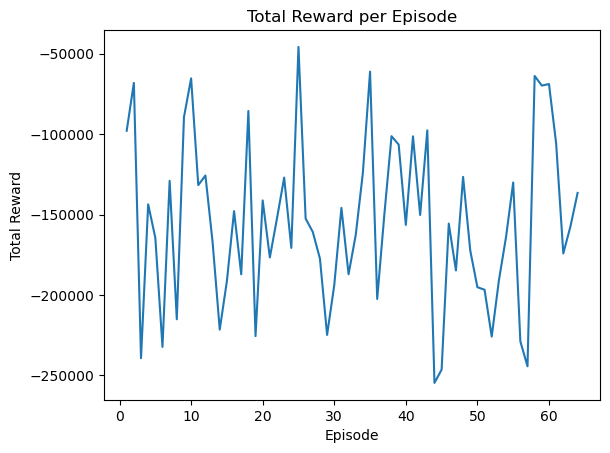

In [9]:
import numpy as np

class CustomRLModel:
    def __init__(self, num_actions, learning_rate, discount_factor, epsilon):
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_values = np.zeros((num_actions))

    def get_new_credit_limit(self, customer_index, action):
        if action == 0:
            return merged_df.loc[customer_index, 'LIMIT_BAL']
        elif action == 1:
            return merged_df.loc[customer_index, 'New Credit Limit']

    def get_outstanding_balance(self, customer_index, action):
        if action == 0:
            return merged_df.loc[customer_index, 'avg_OB']
        elif action == 1:
            return merged_df.loc[customer_index, 'R_a']

    def calculate_provision(self, customer_index, action):
        LGD = 0.45
        CCF = 0.75
        PDn = merged_df.loc[customer_index, 'Probability of Default']
        OB3_n = merged_df.loc[customer_index, 'OB3']
        L_an = self.get_new_credit_limit(customer_index, action)
        provision = PDn * LGD * (OB3_n + CCF * (L_an - OB3_n))
        return provision

    def calculate_provision_change(self, customer_index):
        provision_change = 0
        for i in range(customer_index): 
            action = self.select_action(i)  # Select action based on learned policy
            P_provisions_i_a = self.calculate_provision(i, action)
            P_provisions_i_0 = self.calculate_provision(i, 0)
            provision_change += P_provisions_i_a - P_provisions_i_0
        return provision_change

    def get_state_features(self, customer_index):
        utilization_rates = merged_df.loc[customer_index, 'URn']
        payment_rates = merged_df.loc[customer_index, 'PRn']
        consumption_rates = merged_df.loc[customer_index, 'CRn']
        current_limit = merged_df.loc[customer_index, 'LIMIT_BAL']
        interest_rate = 0.025
        ΔP_rovisions_n_1 = self.calculate_provision_change(customer_index)
        return (utilization_rates, payment_rates, consumption_rates, current_limit, interest_rate, ΔP_rovisions_n_1)

    def calculate_reward(self, customer_index, action):
        Intn = 0.025
        PDn = merged_df.loc[customer_index, 'Probability of Default']
        E_profit_with_action = 3 * Intn * self.get_outstanding_balance(customer_index, 1) * (1 - PDn) - self.calculate_provision(customer_index,1)
        E_profit_without_action = 3 * Intn * self.get_outstanding_balance(customer_index, 0) * (1 - PDn) - self.calculate_provision(customer_index,0)
        reward = E_profit_with_action - E_profit_without_action if action == 1 else 0
        return reward

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_actions)
        else:
            return np.argmax(self.q_values)
        
    def plot_rewards_per_episode(self, episode_rewards):
        plt.plot(range(1, len(episode_rewards) + 1), episode_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Total Reward per Episode')
        plt.show()

    def train(self, num_episodes):
        episode_rewards = []
        for episode in range(num_episodes):
            total_reward = 0
            for customer_index in merged_df.index:
                state = self.get_state_features(customer_index)
                action = self.select_action(state)
                reward = self.calculate_reward(customer_index, action)
                td_target = reward
                self.q_values[action] += self.learning_rate * (td_target - self.q_values[action])
                total_reward += reward
            episode_rewards.append(total_reward)
            print(f"Episode {episode + 1}, Total Reward: {total_reward}")

        self.plot_rewards_per_episode(episode_rewards)
    
    def plot_trajectories(self, num_episodes=5, num_steps=100):
        trajectories = np.random.randint(0, self.num_actions, size=(num_episodes, num_steps))  # Example trajectories
        plt.figure(figsize=(12, 6))
        for i, trajectory in enumerate(trajectories):
            plt.subplot(num_episodes, 1, i+1)
            plt.plot(trajectory)
            plt.xlabel('Time Step')
            plt.ylabel('Action')
            plt.title(f'Episode {i+1} Trajectory')
        plt.tight_layout()
        plt.show()

    def select_actions_for_customers(self):
        actions = []
        for customer_index in merged_df.index:
            state = self.get_state_features(customer_index)
            action = self.select_action(state)
            actions.append(action)
        return actions

# Example usage
num_actions = 2
learning_rate = 0.08
discount_factor = 0.9
epsilon = 0.4
num_episodes = len(merged_df)
model = CustomRLModel(num_actions, learning_rate, discount_factor, epsilon)
model.train(num_episodes)
actions = model.select_actions_for_customers()


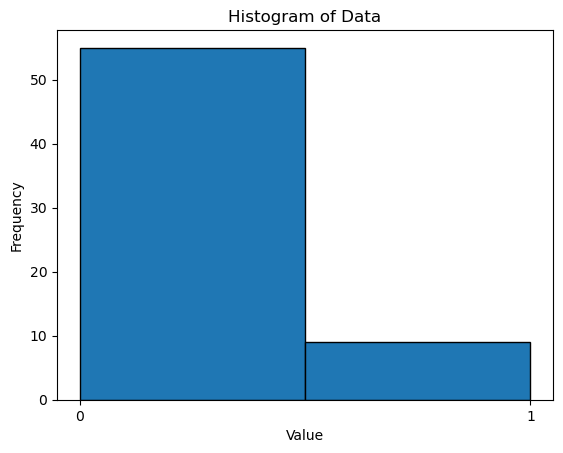

0.140625


In [16]:
plt.hist(actions, bins=2, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.xticks([0, 1])
plt.show()
credit_increase_rate = np.mean(actions)
print(credit_increase_rate)

In [47]:
merged_df['Action'] = actions
merged_df

,CustomerIndex,index,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,EAD,LGD,Probability of Default,New Credit Limit,E(Loss),R_a,URn,PRn,CRn,Action
CustomerIndex,,,,,,,,,,,,,,,,,,,,,
0,0,0,20000,1,2,2,29,0,0,-2,...,17594.110279,0.5,0.469901,30000.0,4133.749119,3153.479792,0.861461,0.000000,0.840450,0
1,1,1,50000,1,2,2,29,1,2,0,...,55299.390551,0.5,0.485621,75000.0,13427.259458,57192.461542,1.042323,0.000000,1.016900,1
2,2,2,260000,1,1,1,30,-1,0,-1,...,8336.407667,0.5,0.470841,390000.0,1962.562490,5392.615708,0.069402,0.365914,0.105300,0
3,3,3,60000,1,3,2,30,0,0,0,...,52201.746109,0.5,0.467119,90000.0,12192.215710,55460.211750,0.895430,0.047314,0.915867,0
4,4,4,50000,1,3,1,30,1,2,2,...,15730.047502,0.5,0.499668,75000.0,3929.898971,13303.874542,0.332319,0.074375,0.349580,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,59,210000,1,2,1,34,3,2,2,...,2624.981175,0.5,0.508457,315000.0,667.344683,2862.328917,0.012202,0.000000,0.011905,0
60,60,60,10000,1,3,1,43,0,0,0,...,2597.507343,0.5,0.473565,15000.0,615.044179,4649.335417,0.702205,0.227221,0.880200,0
61,61,61,80000,1,2,2,34,2,2,2,...,58571.337451,0.5,0.514638,120000.0,15071.508174,78404.550292,0.842137,0.096476,0.906963,0


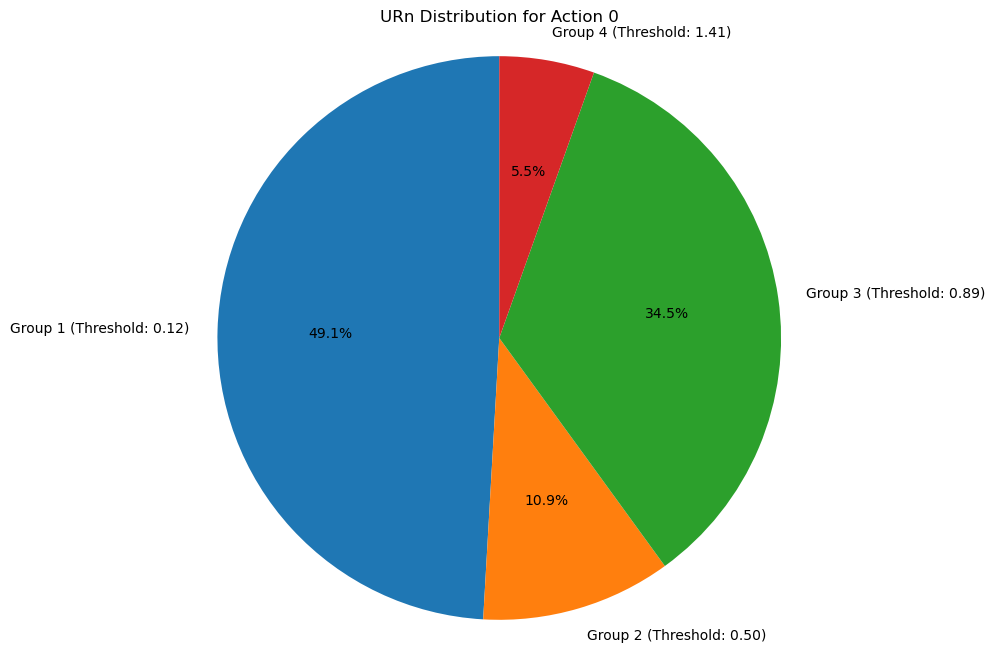

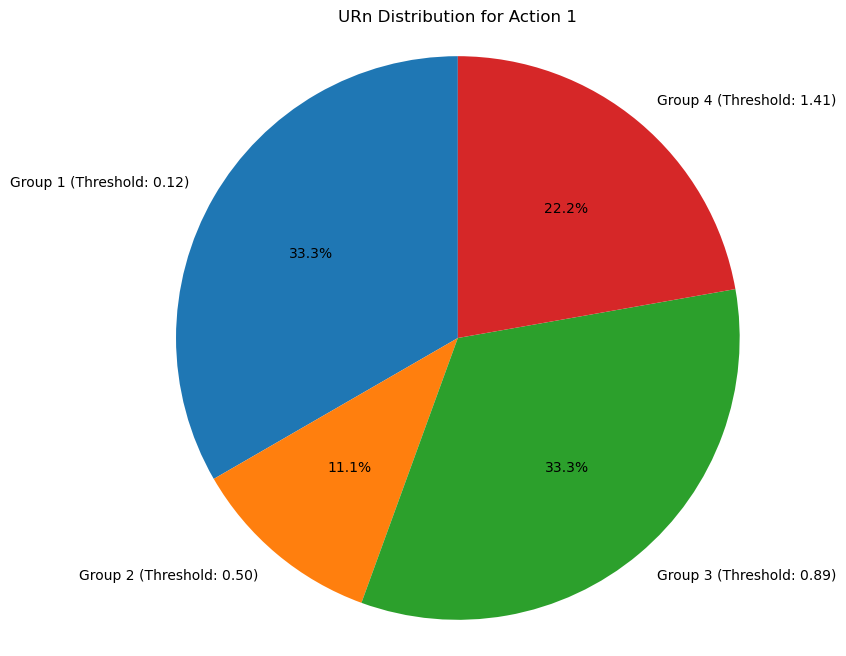

In [56]:
import pandas as pd
# Define the number of groups for URn
# Define the number of groups for URn and calculate thresholds
num_groups = 4
thresholds = merged_df['URn'].describe(percentiles=[i/num_groups for i in range(1, num_groups+1)]).iloc[4:-1].values
# Group URn into num_groups categories
merged_df['URn_group'] = pd.cut(merged_df['URn'], bins=num_groups, labels=[f'Group {i+1}' for i in range(num_groups)])

# Group by 'Action' and 'URn_group', and calculate the counts
grouped = merged_df.groupby(['Action', 'URn_group']).size().reset_index(name='counts')

# Create pie charts for each 'Action' and show the thresholds
for action in [0, 1]:
    subset = grouped[grouped['Action'] == action]
    sizes = subset['counts']
    labels = [f'{label} (Threshold: {thresholds[i]:.2f})' for i, label in enumerate(subset['URn_group'])]
    
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(f'URn Distribution for Action {action}')
    plt.axis('equal')
    plt.show()

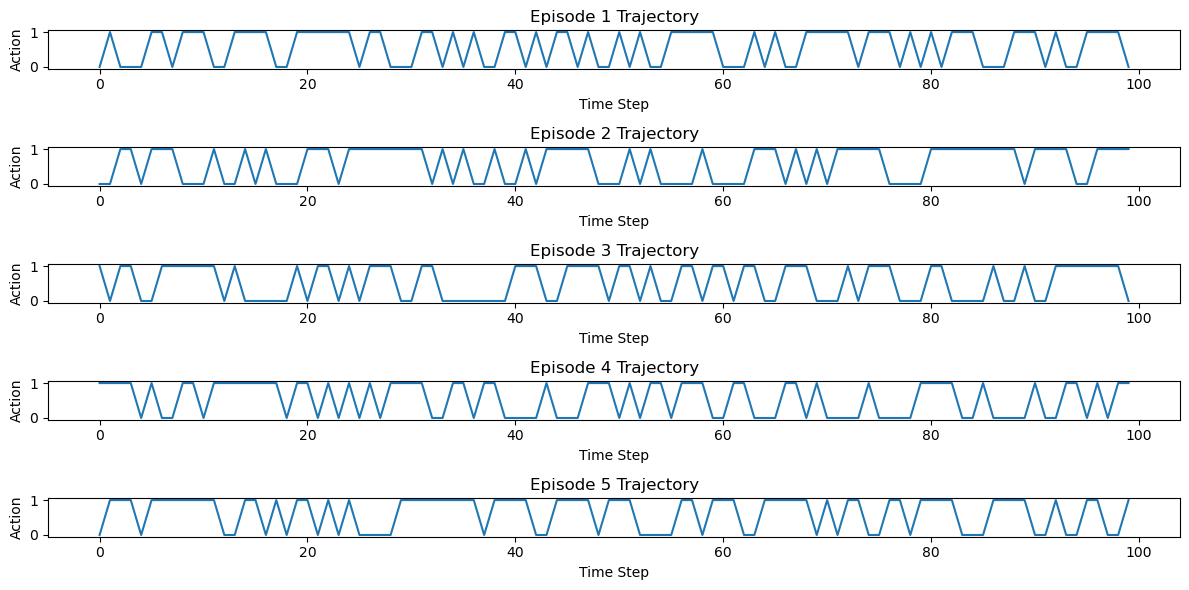

In [11]:
model.plot_trajectories()

Episode 1, Total Reward: -177156.27374518738
Episode 2, Total Reward: -181497.5755744207
Episode 3, Total Reward: -240718.80507044838
Episode 4, Total Reward: -163202.57832878464
Episode 5, Total Reward: -167552.55889359186
Episode 6, Total Reward: -279527.67797445046
Episode 7, Total Reward: -287547.9444092082
Episode 8, Total Reward: -159012.899540893
Episode 9, Total Reward: -141701.11564952348
Episode 10, Total Reward: -159408.95710871302
Episode 11, Total Reward: -86133.49076881094
Episode 12, Total Reward: -240906.94062027094
Episode 13, Total Reward: -247405.56641240997
Episode 14, Total Reward: -184182.59467574055
Episode 15, Total Reward: -251970.36941113512
Episode 16, Total Reward: -210632.83340161055
Episode 17, Total Reward: -213269.03472984178
Episode 18, Total Reward: -123396.59998598321
Episode 19, Total Reward: -128966.76648813249
Episode 20, Total Reward: -183306.59253560018
Episode 21, Total Reward: -146100.03561623086
Episode 22, Total Reward: -185193.27650297494
Ep

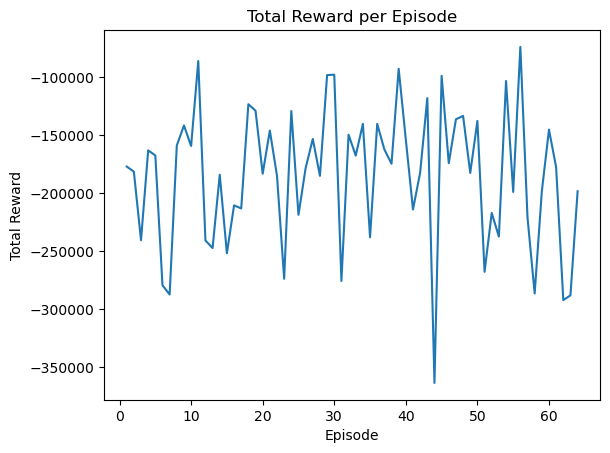

In [12]:
import numpy as np

class CustomRLModel:
    def __init__(self, num_actions, learning_rate, discount_factor, epsilon):
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_values_a = np.zeros((num_actions))
        self.q_values_b = np.zeros((num_actions))
        self.q_values = self.q_values_a

    def get_new_credit_limit(self, customer_index, action):
        if action == 0:
            return merged_df.loc[customer_index, 'LIMIT_BAL']
        elif action == 1:
            return merged_df.loc[customer_index, 'New Credit Limit']

    def get_outstanding_balance(self, customer_index, action):
        if action == 0:
            return merged_df.loc[customer_index, 'avg_OB']
        elif action == 1:
            return merged_df.loc[customer_index, 'R_a']

    def calculate_provision(self, customer_index, action):
        LGD = 0.45
        CCF = 0.75
        PDn = merged_df.loc[customer_index, 'Probability of Default']
        OB3_n = merged_df.loc[customer_index, 'OB3']
        L_an = self.get_new_credit_limit(customer_index, action)
        provision = PDn * LGD * (OB3_n + CCF * (L_an - OB3_n))
        return provision

    def calculate_provision_change(self, customer_index):
        provision_change = 0
        for i in range(customer_index): 
            action = self.select_action(i)  # Select action based on learned policy
            P_provisions_i_a = self.calculate_provision(i, action)
            P_provisions_i_0 = self.calculate_provision(i, 0)
            provision_change += P_provisions_i_a - P_provisions_i_0
        return provision_change

    def get_state_features(self, customer_index):
        utilization_rates = merged_df.loc[customer_index, 'URn']
        payment_rates = merged_df.loc[customer_index, 'PRn']
        consumption_rates = merged_df.loc[customer_index, 'CRn']
        current_limit = merged_df.loc[customer_index, 'LIMIT_BAL']
        interest_rate = 0.025
        ΔP_rovisions_n_1 = self.calculate_provision_change(customer_index)
        return (utilization_rates, payment_rates, consumption_rates, current_limit, interest_rate, ΔP_rovisions_n_1)

    def calculate_reward(self, customer_index, action):
        Intn = 0.025
        PDn = merged_df.loc[customer_index, 'Probability of Default']
        E_profit_with_action = 3 * Intn * self.get_outstanding_balance(customer_index, 1) * (1 - PDn) - self.calculate_provision(customer_index,1)
        E_profit_without_action = 3 * Intn * self.get_outstanding_balance(customer_index, 0) * (1 - PDn) - self.calculate_provision(customer_index,0)
        reward = E_profit_with_action - E_profit_without_action if action == 1 else 0
        return reward

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_actions)
        else:
            return np.argmax(self.q_values)

    def train(self, num_episodes):
        episode_rewards = []
        for episode in range(num_episodes):
            total_reward = 0
            for customer_index in merged_df.index:
                state = self.get_state_features(customer_index)
                action = self.select_action(state)
                reward = self.calculate_reward(customer_index, action)
                if np.random.rand() < 0.5:
                    q_values_prime = self.q_values_a
                    q_values_target = self.q_values_b
                else:
                    q_values_prime = self.q_values_b
                    q_values_target = self.q_values_a
                td_target = reward + self.discount_factor * q_values_target[np.argmax(q_values_prime)]
                q_values_prime[action] += self.learning_rate * (td_target - q_values_prime[action])
                total_reward += reward
            episode_rewards.append(total_reward)
            print(f"Episode {episode + 1}, Total Reward: {total_reward}")
        self.plot_rewards_per_episode(episode_rewards)

    def select_actions_for_customers(self):
        actions = []
        for customer_index in merged_df.index:
            state = self.get_state_features(customer_index)
            action = self.select_action(state)
            actions.append(action)
        return actions
    
    def plot_rewards_per_episode(self, episode_rewards):
        plt.plot(range(1, len(episode_rewards) + 1), episode_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Total Reward per Episode')
        plt.show()

# Example usage
num_actions = 2
learning_rate = 0.05
discount_factor = 0.9
epsilon = 0.4
num_episodes = len(merged_df)
model = CustomRLModel(num_actions, learning_rate, discount_factor, epsilon)
model.train(num_episodes)
actions = model.select_actions_for_customers()